In [94]:
import numpy as np
import random
import torch

# Set seed for NumPy random number generator to ensure reproducibility
np.random.seed(42)

# Set seed for Python built-in random module to ensure reproducibility
random.seed(42)

# Set seed for PyTorch random number generator to ensure reproducibility
torch.manual_seed(42)

# Check if a CUDA-enabled GPU is available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Read dataset + preprocess
I decide to take the whole dataset to increase the score of the lightGCN

In [95]:
import pandas as pd

# Define column names for the DataFrame
columns_name = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the data
df = pd.read_csv("/Users/damirabdulaev/Downloads/ml-100k/u.data", sep="\t", names=columns_name)

In [96]:
from sklearn.model_selection import train_test_split

# Split the DataFrame 'df' into training and test sets
train, test = train_test_split(df.values, test_size=0.2, random_state=16)

# Create new DataFrames 'train_df' and 'test_df' from the split data with the same column names
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

Because of the train/test split we should relabel all users in the dataframes

In [97]:
from sklearn import preprocessing as pp

# Initialize LabelEncoders for 'user_id' and 'item_id'
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()

# Encode 'user_id' and 'item_id' in the training DataFrame and create new columns for the encoded values
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

In [98]:
# Save the train_dataset for future use in testing
train_df.to_csv('train_dataset.csv', index=False)

In [99]:
# Extract unique user and item IDs from the training set
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

# Filter the test set to include only those rows with user and item IDs present in the training set
test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & \
    (test_df['item_id'].isin(train_item_ids))
    ]

In [100]:
# Encode 'user_id' and 'item_id' in the test DataFrame using the previously initialized LabelEncoders
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [101]:
# Save the test_dataset for future use in testing
test_df.to_csv('test_dataset.csv', index=False)

### Minibatch Sampling

Explain the scheme of minibatch positive and negative sample in some amount of prose.

We need to add `n_usr` to the sampled positive and negative items, since each node must have a unique id when using PyG.

In [102]:
import random
import pandas as pd
import torch

def data_loader(data, batch_size, n_usr, n_itm):
    """
    Generate a batch of training data for a recommendation system.

    Args:
    - data (pd.DataFrame): DataFrame containing user-item interaction data.
    - batch_size (int): Number of samples in each batch.
    - n_usr (int): Number of unique user indices.
    - n_itm (int): Number of unique item indices.

    Returns:
    - Tuple of torch.LongTensor: Tuple containing user, positive item, and negative item indices.
    """

    def sample_neg(x):
        """
        Helper function to sample a negative item index not present in the given list.

        Args:
        - x (list): List of positive item indices for a user.

        Returns:
        - int: Negative item index.
        """
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    # Group the data by user indices and create a list of interacted items for each user
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    # Randomly select users for the batch
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users, columns=['users'])

    # Merge the selected users with the interacted_items_df to get positive items
    interected_items_df = pd.merge(interected_items_df, users_df, how='right', left_on='user_id_idx', right_on='users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x: random.choice(x)).values

    # Generate negative items for the selected users
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    # Return the generated data as torch.LongTensor
    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

# Obtain the number of unique users and items from the training data
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()

# Generate a batch of training data using the data_loader function
data_loader(train_df, 16, n_users, n_items)

(tensor([ 25,  89, 104, 114, 142, 228, 250, 281, 558, 604, 654, 692, 754, 758,
         759, 913]),
 tensor([1257, 1469, 1200,  998, 1267, 1254, 1086, 1244, 1122, 1194, 1198, 1510,
         1282, 1164, 1679, 1393]),
 tensor([2497, 1269, 2372, 1808, 1639, 1512, 1261, 1383, 2506, 1632, 1141, 1678,
         1647, 2179, 1484, 1031]))

## Edge Index

In [103]:
# Convert user and item indices to torch LongTensors
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

# Create the edge index for the training data
train_edge_index = torch.stack((
    torch.cat([u_t, i_t]),
    torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 523,  428,  504,  ..., 1128, 1164, 1242],
        [1356, 1034, 1114,  ...,  637,  837,   11]])

## Model Architecture


### LightGCN Convolutional Layer

In [41]:
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree
import numpy as np

class LightGCNConv(MessagePassing):
    """
    Implementation of the LightGCN convolution layer.

    Args:
    - MessagePassing: Base class for implementing message passing layers in PyTorch Geometric.
    """

    def __init__(self, **kwargs):
        """
        Initializes the LightGCN convolution layer.

        Args:
        - **kwargs: Additional keyword arguments for the MessagePassing base class.
        """
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        """
        Forward pass of the LightGCN convolution layer.

        Args:
        - x (torch.Tensor): Node features.
        - edge_index (torch.LongTensor): Graph edge indices.

        Returns:
        - torch.Tensor: Output tensor after the forward pass.
        """
        from_, to_ = edge_index

        # Calculate degree and degree_inv_sqrt for normalization
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Perform the message passing step
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        """
        Message function for the LightGCN convolution layer.

        Args:
        - x_j (torch.Tensor): Input tensor for each neighboring node.
        - norm (torch.Tensor): Normalization factor.

        Returns:
        - torch.Tensor: Output tensor after applying the message function.
        """
        return norm.view(-1, 1) * x_j

### Recommender System GNN

In [42]:
import torch.nn as nn
import torch.nn.functional as F

In [104]:
import torch.nn as nn

class RecSysGNN(nn.Module):
    """
    Implementation of a Graph Neural Network (GNN) for recommendation systems.

    Args:
    - latent_dim (int): Dimensionality of the latent embeddings.
    - num_layers (int): Number of layers in the GNN.
    - num_users (int): Number of unique user indices.
    - num_items (int): Number of unique item indices.
    """

    def __init__(
            self,
            latent_dim,
            num_layers,
            num_users,
            num_items,
    ):
        """
        Initializes the RecSysGNN model.

        Args:
        - latent_dim (int): Dimensionality of the latent embeddings.
        - num_layers (int): Number of layers in the GNN.
        - num_users (int): Number of unique user indices.
        - num_items (int): Number of unique item indices.
        """
        super(RecSysGNN, self).__init__()

        # Embedding layer for users and items
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)

        # List of LightGCNConv layers for message passing
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

        # Initialize parameters
        self.init_parameters()

    def init_parameters(self):
        """
        Initializes the model parameters.
        """
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        """
        Forward pass of the RecSysGNN model.

        Args:
        - edge_index (torch.LongTensor): Graph edge indices.

        Returns:
        - Tuple of torch.Tensor: Tuple containing initial embeddings and final embeddings.
        """
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        """
        Encodes a minibatch of users, positive items, and negative items.

        Args:
        - users (torch.LongTensor): Indices of users in the minibatch.
        - pos_items (torch.LongTensor): Indices of positive items in the minibatch.
        - neg_items (torch.LongTensor): Indices of negative items in the minibatch.
        - edge_index (torch.LongTensor): Graph edge indices.

        Returns:
        - Tuple of torch.Tensor: Tuple containing embeddings for users, positive items, negative items,
          and initial embeddings for users, positive items, negative items.
        """
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

## Bayesian Personalized Ranking loss function + Presicion and Recall

In [105]:
import torch.nn.functional as F

def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
    """
    Compute Bayesian Personalized Ranking (BPR) loss.

    Args:
    - users (torch.LongTensor): Indices of users.
    - users_emb (torch.Tensor): Embeddings for users.
    - pos_emb (torch.Tensor): Embeddings for positive items.
    - neg_emb (torch.Tensor): Embeddings for negative items.
    - user_emb0 (torch.Tensor): Initial embeddings for users.
    - pos_emb0 (torch.Tensor): Initial embeddings for positive items.
    - neg_emb0 (torch.Tensor): Initial embeddings for negative items.

    Returns:
    - Tuple of torch.Tensor: Tuple containing BPR loss and regularization loss.
    """
    # Regularization loss
    reg_loss = (1 / 2) * (
            user_emb0.norm().pow(2) +
            pos_emb0.norm().pow(2) +
            neg_emb0.norm().pow(2)
    ) / float(len(users))

    # BPR loss
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)
    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [106]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    """
    Calculate recall and precision metrics for a recommendation model.

    Args:
    - user_Embed_wts (torch.Tensor): User embeddings.
    - item_Embed_wts (torch.Tensor): Item embeddings.
    - n_users (int): Number of unique users.
    - n_items (int): Number of unique items.
    - train_data (pd.DataFrame): DataFrame containing training data.
    - test_data (pd.DataFrame): DataFrame containing test data.
    - K (int): Top-K recommendations to consider.

    Returns:
    - Tuple of floats: Mean recall and mean precision.
    """
    # Compute relevance scores
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    # Create a sparse tensor representing user-item interactions in the training data
    i = torch.stack((
        torch.LongTensor(train_data['user_id_idx'].values),
        torch.LongTensor(train_data['item_id_idx'].values)
    ))
    v = torch.ones((len(train_data)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)

    # Exclude already interacted items from relevance scores
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # Get top-K relevant item indices
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    # Create a DataFrame with user indices and top-K relevant item indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),
                                             columns=['top_indx_' + str(x + 1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[
        ['top_indx_' + str(x + 1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID', 'top_rlvnt_itm']]

    # Merge test data with top-K relevant item indices
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df, how='left',
                          left_on='user_id_idx', right_on=['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in
                                  zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    # Calculate recall and precision
    metrics_df['recall'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / len(x['item_id_idx']), axis=1)
    metrics_df['precision'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / K, axis=1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## Train and evaluate models

Lets test lightGCN metrics after training:

In [108]:
# Define the hyperparameters
latent_dim = 64
n_layers = 3

EPOCHS = 40
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [109]:
from tqdm import tqdm

def train_and_eval(model, optimizer, train_df):
    """
    Train and evaluate the recommendation model.

    Args:
    - model: Instance of the recommendation model.
    - optimizer: PyTorch optimizer.
    - train_df (pd.DataFrame): DataFrame containing training data.

    Returns:
    - Tuple of lists: Lists containing epoch-wise losses, BPR losses, regularization losses,
      recall scores, and precision scores.
    """
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []
    recall_list = []
    precision_list = []

    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train_df) / BATCH_SIZE)

        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []

        model.train()
        for batch_idx in range(n_batch):
            optimizer.zero_grad()

            users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items,
                                                                                             train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall, test_topK_precision = get_metrics(
                final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
            )

        loss_list_epoch.append(round(np.mean(final_loss_list), 4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list), 4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))
        recall_list.append(round(test_topK_recall, 4))
        precision_list.append(round(test_topK_precision, 4))

    return (
        loss_list_epoch,
        bpr_loss_list_epoch,
        reg_loss_list_epoch,
        recall_list,
        precision_list
    )

### Train and eval LightGCN

In [110]:
from tqdm.notebook import tqdm

# Instantiate the RecSysGNN model
lightgcn = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
)
lightgcn.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

In [84]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/40 [00:00<?, ?it/s]

In [58]:
epoch_list = [(i+1) for i in range(EPOCHS)]

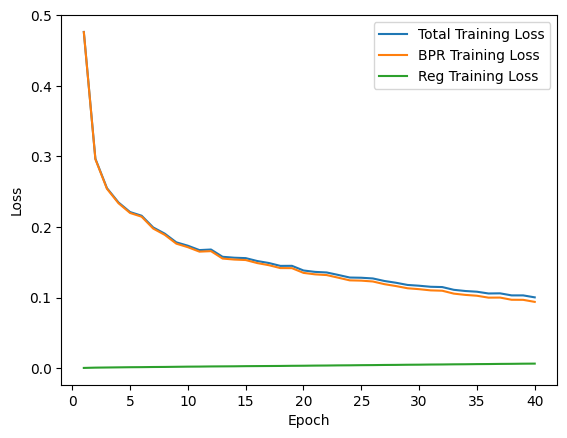

In [111]:
import matplotlib.pyplot as plt

# Plot training losses
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

# Set plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

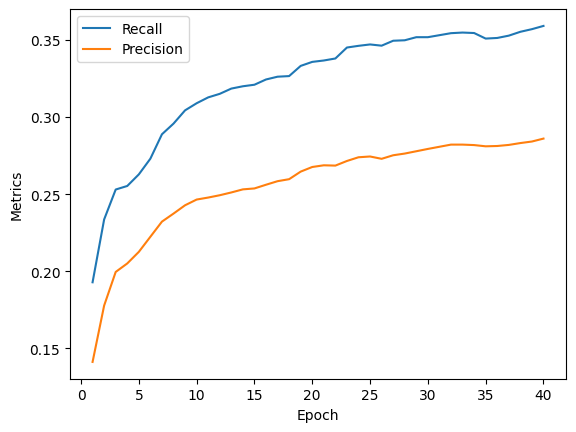

In [112]:
import matplotlib.pyplot as plt

# Plot recall and precision
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')

# Set plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

# Show the plot
plt.show()

### Model perfomance (Benchmark)

In [113]:
max(light_precision), max(light_recall)

(0.286, 0.359)

## Save the model:

In [114]:
torch.save(lightgcn, 'best_40e.pth')